# Homework 10: GAN, VAE

## GAN - DCGAN
- Anime Face Dataset 을 DCGAN 에 활용해 이미지를 생성해보자

In [1]:
import abc
import tensorflow as tf
from keras import Sequential, Input
from keras.layers import Conv2D, LeakyReLU, Flatten, Dropout, Dense, Reshape, Conv2DTranspose
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown

In [2]:
dataset = keras.preprocessing.image_dataset_from_directory(
    "/Users/lifeofpy/ADL/", label_mode=None, image_size=(64, 64), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)

Found 63565 files belonging to 3 classes.


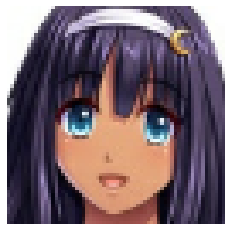

In [3]:
# Sample Image
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

In [4]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        # layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        # layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dropout (Dropout)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 1)               

In [5]:
latent_dim = 100

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(30, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8192)              827392    
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 64)        131136    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 64, 64, 30)        30

In [6]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [7]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            plt.imshow(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))

In [8]:
epochs = 10

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

In [9]:
gan.fit(
    dataset, epochs=epochs,
)

Epoch 1/10
1987/1987 [==============================] - 980s 493ms/step - d_loss: 0.4565 - g_loss: 1.6969
Epoch 2/10
1987/1987 [==============================] - 1275s 642ms/step - d_loss: 0.5142 - g_loss: 1.3800
Epoch 3/10
1987/1987 [==============================] - 1042s 525ms/step - d_loss: 0.5023 - g_loss: 1.3351
Epoch 4/10
1987/1987 [==============================] - 934s 470ms/step - d_loss: 0.4992 - g_loss: 1.5239
Epoch 5/10
1987/1987 [==============================] - 899s 452ms/step - d_loss: 0.5265 - g_loss: 1.2805
Epoch 6/10
1987/1987 [==============================] - 30665s 15s/step - d_loss: 0.5436 - g_loss: 1.2281
Epoch 7/10
1987/1987 [==============================] - 6822s 3s/step - d_loss: 0.6202 - g_loss: 1.0807
Epoch 8/10
1987/1987 [==============================] - 6395s 3s/step - d_loss: 0.6392 - g_loss: 1.0375
Epoch 9/10
1987/1987 [==============================] - 9187s 5s/step - d_loss: 0.6780 - g_loss: 1.0084
Epoch 10/10
1987/1987 [===========================

## Results with DCGAN

In [15]:
test = generator.predict(tf.random.normal(shape=(10, latent_dim)))

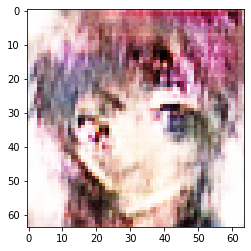

In [11]:
# generation 의 결과
plt.imshow(test[0])

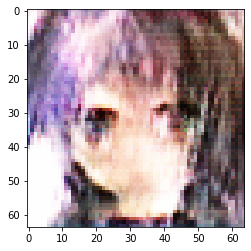

In [12]:
plt.imshow(test[1])

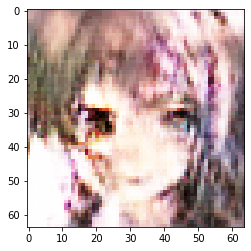

In [18]:
plt.imshow(test[2])

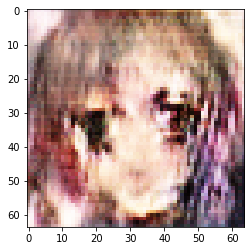

In [19]:
plt.imshow(test[3])

# VAE
- MNIST Dataset 을 VAE 에 사용해 이미지를 생성해보자

In [26]:
import pandas as pd
import numpy as np
import keras
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Activation, LeakyReLU, Dropout, BatchNormalization, MaxPooling2D, Lambda
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import mean_squared_error as mse
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [27]:
(Xtrain, Ytrain), (Xtest, Ytest) = keras.datasets.mnist.load_data()
Xtrain = Xtrain/255
Xtest = Xtest/255

Xtrain = Xtrain.reshape(len(Xtrain), 28, 28, 1)
Xtest = Xtest.reshape(len(Xtest), 28, 28, 1)

Ytrain = to_categorical(Ytrain)
Ytest = to_categorical(Ytest)

In [28]:
#Encoder
encoder_input=Input(shape=(28,28,1))

x=Conv2D(filters=32, kernel_size=3, strides=1, padding='same')(encoder_input)
x=LeakyReLU()(x)

x=Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(x)
x=LeakyReLU()(x)

x=Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(x)
x=LeakyReLU()(x)

x=Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(x)
x=LeakyReLU()(x)

shape_before_flatten=K.int_shape(x)[1:]
x=Flatten()(x)

#############################################################################
mu=Dense(units=2)(x)
log_var=Dense(units=2)(x)

def sampling(args):
    mu, log_var = args
    epsilon = K.random_normal(shape=K.shape(mu), mean=0, stddev=1)
    return mu + K.exp(log_var / 2) * epsilon

encoder_output=Lambda(sampling)([mu, log_var])
model_encoder = Model(encoder_input, encoder_output)
############################################################################
print(model_encoder.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_12 (LeakyReLU)      (None, 28, 28, 32)   0           conv2d_7[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 14, 14, 64)   18496       leaky_re_lu_12[0][0]             
____________________________________________________________________________________________

In [29]:
#Decoder
decoder_input=Input(shape=(2,))
x=Dense(units=np.prod(shape_before_flatten))(decoder_input)
x=Reshape(shape_before_flatten)(x)

x=Conv2DTranspose(filters=64, kernel_size=3, strides=1, padding='same')(x)
x=LeakyReLU()(x)

x=Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same')(x)
x=LeakyReLU()(x)

x=Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same')(x)
x=LeakyReLU()(x)

x=Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same')(x)
x=Activation('sigmoid')(x)

decoder_output=x
model_decoder=Model(decoder_input, decoder_output)
print(model_decoder.summary())


#Connect Two Models
model_input = encoder_input
model_output = model_decoder(encoder_output)

AutoEncoder=Model(model_input, model_output)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_7 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 14, 14, 64)        0   

In [30]:
optimizer=Adam(lr=0.0005)
r_loss_factor=1000   # This is a Hyperparameter

def vae_r_loss(y_true, y_pred):    ## MSE
    r_loss = K.mean(K.square(y_true-y_pred), axis=[1,2,3])
    return r_loss_factor * r_loss

def vae_kl_loss(y_true, y_pred):   ## KL-Divergence
    kl_loss= -0.5 * K.sum(1+log_var - K.square(mu) - K.exp(log_var), axis=1)
    return kl_loss

def vae_loss(y_true, y_pred): 
    r_loss=vae_r_loss(y_true, y_pred) #Loss of Decoder
    kl_loss = vae_kl_loss(y_true, y_pred) #Loss of Encoder
    return r_loss + kl_loss #Sum of these two


AutoEncoder.compile(optimizer=optimizer, loss= vae_loss, metrics=[vae_r_loss, vae_kl_loss])

Trial 0...
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 170s 3ms/sample - loss: 55.7859 - vae_r_loss: 52.5067 - vae_kl_loss: 3.2792
Epoch 2/10
60000/60000 [==============================] - 104s 2ms/sample - loss: 51.6922 - vae_r_loss: 47.7670 - vae_kl_loss: 3.9253
Epoch 3/10
60000/60000 [==============================] - 90s 2ms/sample - loss: 50.2263 - vae_r_loss: 45.9770 - vae_kl_loss: 4.2493
Epoch 4/10
60000/60000 [==============================] - 80s 1ms/sample - loss: 49.2583 - vae_r_loss: 44.8316 - vae_kl_loss: 4.4267
Epoch 5/10
60000/60000 [==============================] - 85s 1ms/sample - loss: 48.5917 - vae_r_loss: 44.0294 - vae_kl_loss: 4.5623
Epoch 6/10
60000/60000 [==============================] - 80s 1ms/sample - loss: 48.1255 - vae_r_loss: 43.4591 - vae_kl_loss: 4.6664
Epoch 7/10
60000/60000 [==============================] - 80s 1ms/sample - loss: 47.6686 - vae_r_loss: 42.9187 - vae_kl_loss: 4.7499
Epoch 8/10
60000/60000 [=========

/Users/lifeofpy/opt/anaconda3/envs/lifeofpy/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


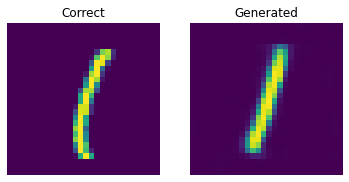

Trial 1...
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 85s 1ms/sample - loss: 46.7750 - vae_r_loss: 41.8588 - vae_kl_loss: 4.9163
Epoch 2/10
60000/60000 [==============================] - 88s 1ms/sample - loss: 46.6125 - vae_r_loss: 41.6544 - vae_kl_loss: 4.9581
Epoch 3/10
60000/60000 [==============================] - 105s 2ms/sample - loss: 46.4660 - vae_r_loss: 41.4844 - vae_kl_loss: 4.9815
Epoch 4/10
60000/60000 [==============================] - 100s 2ms/sample - loss: 46.3336 - vae_r_loss: 41.3357 - vae_kl_loss: 4.9978
Epoch 5/10
60000/60000 [==============================] - 100s 2ms/sample - loss: 46.2273 - vae_r_loss: 41.1933 - vae_kl_loss: 5.0341
Epoch 6/10
60000/60000 [==============================] - 100s 2ms/sample - loss: 46.1207 - vae_r_loss: 41.0737 - vae_kl_loss: 5.0470
Epoch 7/10
60000/60000 [==============================] - 91s 2ms/sample - loss: 46.0150 - vae_r_loss: 40.9588 - vae_kl_loss: 5.0562
Epoch 8/10
60000/60000 [=======

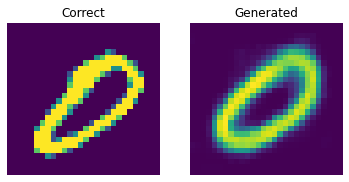

Trial 2...
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 88s 1ms/sample - loss: 45.6742 - vae_r_loss: 40.5480 - vae_kl_loss: 5.1261
Epoch 2/10
60000/60000 [==============================] - 87s 1ms/sample - loss: 45.6246 - vae_r_loss: 40.4859 - vae_kl_loss: 5.1387
Epoch 3/10
60000/60000 [==============================] - 98s 2ms/sample - loss: 45.5660 - vae_r_loss: 40.4055 - vae_kl_loss: 5.1604
Epoch 4/10
60000/60000 [==============================] - 85s 1ms/sample - loss: 45.4974 - vae_r_loss: 40.3322 - vae_kl_loss: 5.1651
Epoch 5/10
60000/60000 [==============================] - 90s 1ms/sample - loss: 45.4333 - vae_r_loss: 40.2485 - vae_kl_loss: 5.1848
Epoch 6/10
60000/60000 [==============================] - 110s 2ms/sample - loss: 45.3534 - vae_r_loss: 40.1703 - vae_kl_loss: 5.1831
Epoch 7/10
60000/60000 [==============================] - 94s 2ms/sample - loss: 45.2986 - vae_r_loss: 40.1014 - vae_kl_loss: 5.1972
Epoch 8/10
60000/60000 [==========

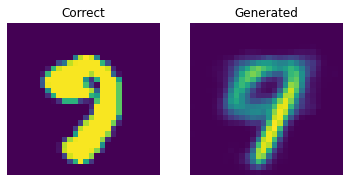

Trial 3...
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 82s 1ms/sample - loss: 45.1079 - vae_r_loss: 39.8775 - vae_kl_loss: 5.2304
Epoch 2/10
60000/60000 [==============================] - 83s 1ms/sample - loss: 45.0762 - vae_r_loss: 39.8431 - vae_kl_loss: 5.2330
Epoch 3/10
60000/60000 [==============================] - 86s 1ms/sample - loss: 45.0486 - vae_r_loss: 39.8067 - vae_kl_loss: 5.2420
Epoch 4/10
60000/60000 [==============================] - 86s 1ms/sample - loss: 44.9993 - vae_r_loss: 39.7495 - vae_kl_loss: 5.2498
Epoch 5/10
60000/60000 [==============================] - 85s 1ms/sample - loss: 44.9483 - vae_r_loss: 39.6835 - vae_kl_loss: 5.2648
Epoch 6/10
60000/60000 [==============================] - 84s 1ms/sample - loss: 44.9190 - vae_r_loss: 39.6565 - vae_kl_loss: 5.2626
Epoch 7/10
60000/60000 [==============================] - 85s 1ms/sample - loss: 44.8782 - vae_r_loss: 39.6171 - vae_kl_loss: 5.2611
Epoch 8/10
60000/60000 [===========

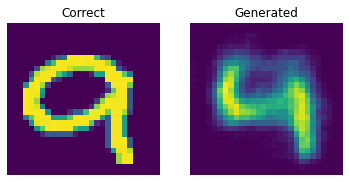

Trial 4...
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 79s 1ms/sample - loss: 44.7510 - vae_r_loss: 39.4582 - vae_kl_loss: 5.2928
Epoch 2/10
60000/60000 [==============================] - 84s 1ms/sample - loss: 44.7082 - vae_r_loss: 39.4103 - vae_kl_loss: 5.2979
Epoch 3/10
60000/60000 [==============================] - 98s 2ms/sample - loss: 44.7002 - vae_r_loss: 39.3922 - vae_kl_loss: 5.3079
Epoch 4/10
60000/60000 [==============================] - 97s 2ms/sample - loss: 44.6656 - vae_r_loss: 39.3444 - vae_kl_loss: 5.3213
Epoch 5/10
60000/60000 [==============================] - 90s 2ms/sample - loss: 44.6541 - vae_r_loss: 39.3336 - vae_kl_loss: 5.3204
Epoch 6/10
60000/60000 [==============================] - 89s 1ms/sample - loss: 44.5840 - vae_r_loss: 39.2648 - vae_kl_loss: 5.3192
Epoch 7/10
60000/60000 [==============================] - 93s 2ms/sample - loss: 44.5573 - vae_r_loss: 39.2348 - vae_kl_loss: 5.3225
Epoch 8/10
60000/60000 [===========

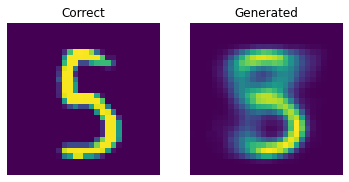

Trial 5...
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 95s 2ms/sample - loss: 44.4548 - vae_r_loss: 39.1079 - vae_kl_loss: 5.3470
Epoch 2/10
60000/60000 [==============================] - 95s 2ms/sample - loss: 44.4571 - vae_r_loss: 39.1062 - vae_kl_loss: 5.3509
Epoch 3/10
60000/60000 [==============================] - 99s 2ms/sample - loss: 44.4087 - vae_r_loss: 39.0577 - vae_kl_loss: 5.3509
Epoch 4/10
60000/60000 [==============================] - 95s 2ms/sample - loss: 44.3858 - vae_r_loss: 39.0269 - vae_kl_loss: 5.3589
Epoch 5/10
60000/60000 [==============================] - 95s 2ms/sample - loss: 44.3585 - vae_r_loss: 39.0009 - vae_kl_loss: 5.3576
Epoch 6/10
60000/60000 [==============================] - 98s 2ms/sample - loss: 44.3589 - vae_r_loss: 38.9803 - vae_kl_loss: 5.3786
Epoch 7/10
60000/60000 [==============================] - 96s 2ms/sample - loss: 44.3166 - vae_r_loss: 38.9387 - vae_kl_loss: 5.3779
Epoch 8/10
60000/60000 [===========

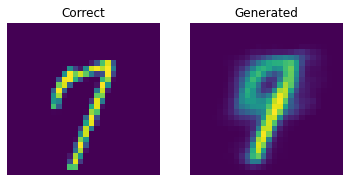

Trial 6...
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 97s 2ms/sample - loss: 44.2632 - vae_r_loss: 38.8733 - vae_kl_loss: 5.3899
Epoch 2/10
60000/60000 [==============================] - 99s 2ms/sample - loss: 44.2115 - vae_r_loss: 38.8268 - vae_kl_loss: 5.3847
Epoch 3/10
60000/60000 [==============================] - 99s 2ms/sample - loss: 44.2254 - vae_r_loss: 38.8366 - vae_kl_loss: 5.3888
Epoch 4/10
60000/60000 [==============================] - 100s 2ms/sample - loss: 44.2029 - vae_r_loss: 38.8067 - vae_kl_loss: 5.3962
Epoch 5/10
60000/60000 [==============================] - 99s 2ms/sample - loss: 44.1816 - vae_r_loss: 38.7728 - vae_kl_loss: 5.4088
Epoch 6/10
60000/60000 [==============================] - 98s 2ms/sample - loss: 44.1563 - vae_r_loss: 38.7489 - vae_kl_loss: 5.4074
Epoch 7/10
60000/60000 [==============================] - 100s 2ms/sample - loss: 44.1111 - vae_r_loss: 38.7072 - vae_kl_loss: 5.4039
Epoch 8/10
60000/60000 [=========

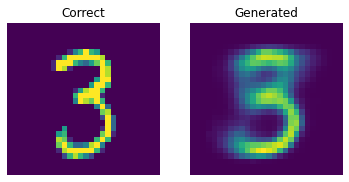

Trial 7...
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 104s 2ms/sample - loss: 44.1067 - vae_r_loss: 38.6933 - vae_kl_loss: 5.4134
Epoch 2/10
60000/60000 [==============================] - 87s 1ms/sample - loss: 44.0521 - vae_r_loss: 38.6412 - vae_kl_loss: 5.4110
Epoch 3/10
60000/60000 [==============================] - 76s 1ms/sample - loss: 44.0187 - vae_r_loss: 38.5887 - vae_kl_loss: 5.4300
Epoch 4/10
60000/60000 [==============================] - 75s 1ms/sample - loss: 44.0310 - vae_r_loss: 38.6011 - vae_kl_loss: 5.4299
Epoch 5/10
60000/60000 [==============================] - 76s 1ms/sample - loss: 43.9923 - vae_r_loss: 38.5620 - vae_kl_loss: 5.4303
Epoch 6/10
60000/60000 [==============================] - 76s 1ms/sample - loss: 44.0111 - vae_r_loss: 38.5885 - vae_kl_loss: 5.4226
Epoch 7/10
60000/60000 [==============================] - 75s 1ms/sample - loss: 43.9809 - vae_r_loss: 38.5537 - vae_kl_loss: 5.4271
Epoch 8/10
60000/60000 [==========

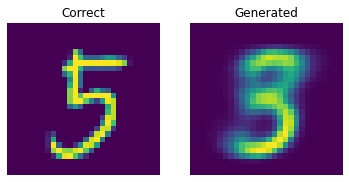

Trial 8...
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 81s 1ms/sample - loss: 43.9165 - vae_r_loss: 38.4631 - vae_kl_loss: 5.4534
Epoch 2/10
60000/60000 [==============================] - 78s 1ms/sample - loss: 43.9279 - vae_r_loss: 38.4820 - vae_kl_loss: 5.4460
Epoch 3/10
60000/60000 [==============================] - 77s 1ms/sample - loss: 43.8738 - vae_r_loss: 38.4231 - vae_kl_loss: 5.4507
Epoch 4/10
60000/60000 [==============================] - 77s 1ms/sample - loss: 43.8912 - vae_r_loss: 38.4570 - vae_kl_loss: 5.4342
Epoch 5/10
60000/60000 [==============================] - 77s 1ms/sample - loss: 43.8458 - vae_r_loss: 38.3985 - vae_kl_loss: 5.4473
Epoch 6/10
60000/60000 [==============================] - 77s 1ms/sample - loss: 43.8494 - vae_r_loss: 38.3831 - vae_kl_loss: 5.4663
Epoch 7/10
60000/60000 [==============================] - 77s 1ms/sample - loss: 43.8215 - vae_r_loss: 38.3610 - vae_kl_loss: 5.4604
Epoch 8/10
60000/60000 [===========

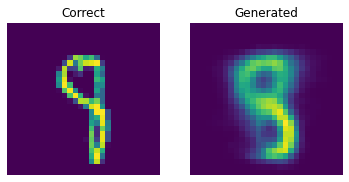

Trial 9...
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 1081s 18ms/sample - loss: 43.7984 - vae_r_loss: 38.3329 - vae_kl_loss: 5.4655
Epoch 2/10
60000/60000 [==============================] - 7098s 118ms/sample - loss: 43.8130 - vae_r_loss: 38.3377 - vae_kl_loss: 5.4753
Epoch 3/10
60000/60000 [==============================] - 73s 1ms/sample - loss: 43.8020 - vae_r_loss: 38.3254 - vae_kl_loss: 5.4766
Epoch 4/10
60000/60000 [==============================] - 98s 2ms/sample - loss: 43.7494 - vae_r_loss: 38.2808 - vae_kl_loss: 5.4685
Epoch 5/10
60000/60000 [==============================] - 80s 1ms/sample - loss: 43.7236 - vae_r_loss: 38.2472 - vae_kl_loss: 5.4764
Epoch 6/10
60000/60000 [==============================] - 73s 1ms/sample - loss: 43.7245 - vae_r_loss: 38.2575 - vae_kl_loss: 5.4670
Epoch 7/10
60000/60000 [==============================] - 73s 1ms/sample - loss: 43.7375 - vae_r_loss: 38.2598 - vae_kl_loss: 5.4777
Epoch 8/10
60000/60000 [====

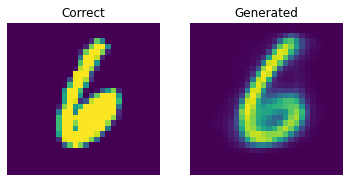

In [32]:
for i in range(10):
    print(f"Trial {i}...")
    AutoEncoder.fit(Xtrain, Xtrain, batch_size=32, shuffle=True, epochs=10)
    result=AutoEncoder.predict(Xtrain)
    
    random=np.random.randint(0, len(Xtrain))
    
    fig = plt.figure()
    rows = 1
    cols = 2
    img1 = Xtrain[random].reshape(28,28)
    img2 = result[random].reshape(28,28)
    ax1 = fig.add_subplot(rows, cols, 1)
    ax1.imshow(img1)
    ax1.set_title('Correct')
    ax1.axis("off")
    ax2 = fig.add_subplot(rows, cols, 2)
    ax2.imshow(img2)
    ax2.set_title('Generated')
    ax2.axis("off")
    plt.show()